In [6]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [7]:
!pip install --upgrade numpy  # Upgrade NumPy to the latest version
!pip install --upgrade --force-reinstall gensim  # Reinstall gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp3

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from gensim.similarities import WmdSimilarity
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Enhancements:
# - Added Bidirectional LSTM for better sequence understanding.
# - Included Attention layer for improved focus on relevant parts of input.
# - Added Adam optimizer with learning rate scheduling.
# - Included ReduceLROnPlateau for adaptive learning rate adjustments.


In [2]:
# Ensure required nltk packages are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Enhances lemmatization
nltk.download('averaged_perceptron_tagger')  # Useful for POS tagging


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
# Load dataset with proper encoding and error handling
file_path = "/content/mohler_dataset_edited.csv"
df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')

# Drop duplicate rows if any
df.drop_duplicates(inplace=True)

# Fill missing values with empty strings
df.fillna("", inplace=True)


In [5]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
# Apply preprocessing, handling potential KeyError
desired_answer_col = 'desired_answer'  # Or the actual column name in your CSV
student_answer_col = 'student_answer'  # Or the actual column name in your CSV

if desired_answer_col in df.columns:
    df[desired_answer_col] = df[desired_answer_col].apply(preprocess_text)
else:
    print(f"Warning: Column '{desired_answer_col}' not found in DataFrame.")

if student_answer_col in df.columns:
    df[student_answer_col] = df[student_answer_col].apply(preprocess_text)
else:
    print(f"Warning: Column '{student_answer_col}' not found in DataFrame.")

NameError: name 'preprocess_text' is not defined

In [ ]:


def preprocess_text(text):
    """
    Preprocesses text by converting to lowercase, removing punctuation,
    tokenizing, removing stop words, lemmatizing, and joining back into a string.

    Handles missing or non-string values by returning an empty string.
    """
    if pd.isna(text) or not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]  # Remove short words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing, using the original column names
df['desired_answer'] = df['desired_answer'].apply(preprocess_text)  # Use 'desired_answer'
df['student_answer'] = df['student_answer'].apply(preprocess_text)  # Use 'student_answer'

In [ ]:
import gensim.downloader as api

# Load pre-trained Word2Vec model (with caching to speed up subsequent loads)
try:
    word_vectors = api.load("word2vec-google-news-300")
    print("Pre-trained Word2Vec model loaded successfully.")
except Exception as e:
    print(f"Error loading Word2Vec model: {e}")


[==================================================] 100.0% 1662.8/1662.8MB downloaded
Pre-trained Word2Vec model loaded successfully.


In [ ]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 19.7 MB/s eta 0:00:00


In [ ]:
import ot

In [ ]:
def compute_wmd(text1, text2):
    text1_tokens = [word for word in text1.split() if word in word_vectors]
    text2_tokens = [word for word in text2.split() if word in word_vectors]

    if not text1_tokens or not text2_tokens:
        return np.inf  # Return a large distance if either document has no words in vocabulary

    return word_vectors.wmdistance(text1_tokens, text2_tokens)

def compute_cosine_similarity(text1, text2, vectorizer):
    try:
        text_vectors = vectorizer.transform([text1, text2])
        return cosine_similarity(text_vectors[0], text_vectors[1])[0][0]
    except Exception as e:
        print(f"Cosine similarity error: {e}")
        return 0  # Return 0 if an error occurs

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
corpus = df['desired_answer'].tolist() + df['student_answer'].tolist()
tfidf_vectorizer.fit(corpus)

# Compute Cosine Similarity and Word Mover's Distance
cosine_similarities = []
wmd_similarities = []
for index in df.index:  # Iterate using the actual DataFrame index
    cosine_sim = compute_cosine_similarity(df.loc[index, 'desired_answer'], df.loc[index, 'student_answer'], tfidf_vectorizer)
    wmd_sim = compute_wmd(df.loc[index, 'desired_answer'], df.loc[index, 'student_answer'])
    cosine_similarities.append(cosine_sim)
    wmd_similarities.append(wmd_sim)

df['Cosine_Similarity'] = cosine_similarities
df['WMD_Similarity'] = wmd_similarities

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# --- Normalization ---
# Ensure there are no NaN or Inf values in similarity scores
df['Cosine_Similarity'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['WMD_Similarity'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the column mean
df['Cosine_Similarity'].fillna(df['Cosine_Similarity'].mean(), inplace=True)
df['WMD_Similarity'].fillna(df['WMD_Similarity'].mean(), inplace=True)

# Normalize Features
scaler = MinMaxScaler()
df[['Cosine_Similarity', 'WMD_Similarity']] = scaler.fit_transform(df[['Cosine_Similarity', 'WMD_Similarity']])



<ipython-input-20-baad748be357>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cosine_Similarity'].replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-20-baad748be357>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 1. Handle Missing Values and Data Type:
df["student_answer"] = df["student_answer"].fillna("").astype(str)  # Use 'student_answer' (case-sensitive)

# 2. Tokenization and Sequencing:
tokenizer = Tokenizer(oov_token="<OOV>")  # Handle out-of-vocabulary words
tokenizer.fit_on_texts(df["student_answer"])
X_sequences = tokenizer.texts_to_sequences(df["student_answer"])

# 3. Padding:
max_length = 100  # Adjust based on your data; consider using statistics (e.g., percentile)
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding="post", truncating="post")

# 4. Target Variable:
y = df["score_avg"].fillna(df["score_avg"].mean()).astype(float)  # Impute with mean if necessary

# 5. Train-Test Split:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [ ]:
# Reshape input for LSTM: (samples, timesteps=1, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Define LSTM Model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.5),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Train with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test), epochs=50, batch_size=32, callbacks=[early_stopping])


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 149.1391 - mae: 7.6967 - val_loss: 21.3057 - val_mae: 3.7476
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 54.5908 - mae: 4.8503 - val_loss: 19.8653 - val_mae: 3.4607
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.6917 - mae: 3.9786 - val_loss: 15.8160 - val_mae: 3.3426
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.3159 - mae: 4.0357 - val_loss: 11.4940 - val_mae: 3.0889
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.1555 - mae: 3.7334 - val_loss: 11.9144 - val_mae: 3.0117
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.7573 - mae: 3.4141 - val_loss: 10.4695 - val_mae: 2.9474
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.4098 - mae: 3.3498 - val_loss: 9.6603 - val_mae: 2.8483
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.2772 - mae: 3.2213 - val_loss: 9.4274 - val_mae: 2.7954
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss

In [ ]:
# Evaluate model
y_pred = model.predict(X_test_lstm)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
Mean Squared Error: 1.2626244854812931
Mean Absolute Error: 0.8968413097286656
R² Score: -0.03129060327653521


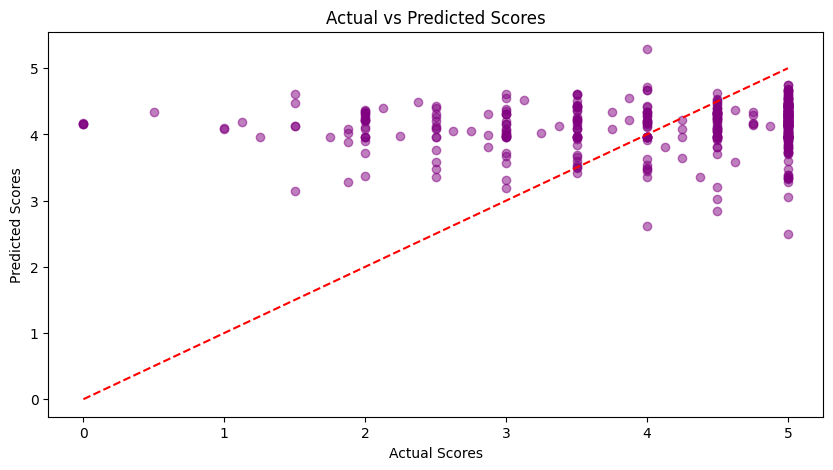

In [ ]:
# Predictions vs Actual Scores
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # Ideal line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores')
plt.show()

In [ ]:
# Example prediction
def predict_score(student_answer, desired_answer):
    student_answer = preprocess_text(student_answer)
    desired_answer = preprocess_text(desired_answer)
    cosine_sim = compute_cosine_similarity(student_answer, desired_answer, tfidf_vectorizer)
    wmd_sim = compute_wmd(student_answer, desired_answer)
    features = np.array([[cosine_sim, wmd_sim]])
    predicted_score = model.predict(features)[0][0]
    return predicted_score

# Test example
example_student_answer = "An array is a collection of elements stored in contiguous memory locations."
example_desired_answer = "An array is a collection of elements identified by an index."
predicted_score = predict_score(example_student_answer, example_desired_answer)
print(f"Predicted Score: {predicted_score}")

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(1, 2), dtype=float32). Expected shape (None, 1, 100), but input has incompatible shape (1, 2)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 2), dtype=float32)
  • training=False
  • mask=None

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# 1. Handle Missing Values and Data Type:
df["student_answer"] = df["student_answer"].fillna("").astype(str)

# 2. Tokenization and Sequencing:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df["student_answer"])
X_sequences = tokenizer.texts_to_sequences(df["student_answer"])

# 3. Padding:
max_length = 100  # Adjust based on your data; consider using statistics (e.g., percentile)
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding="post", truncating="post")

# 4. Target Variable:
y = df["score_avg"].fillna(df["score_avg"].mean()).astype(float)

# 5. Train-Test Split:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# --- Model Enhancement ---
vocab_size = len(tokenizer.word_index) + 1  # +1 for <OOV>
embedding_dim = 100  # Adjust embedding dimension

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),  # Bidirectional LSTM
    Dropout(0.2),  # Dropout for regularization
    Bidirectional(LSTM(32)),  # Another Bidirectional LSTM layer
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile with Adam optimizer and learning rate scheduling
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  # Adjust as needed
    batch_size=32,  # Adjust as needed
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 437ms/step - loss: 8.1868 - mae: 2.3390 - val_loss: 1.2215 - val_mae: 0.8814 - learning_rate: 0.0010
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 242ms/step - loss: 1.3806 - mae: 0.9438 - val_loss: 1.2202 - val_mae: 0.8628 - learning_rate: 0.0010
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - loss: 1.3161 - mae: 0.9257 - val_loss: 1.2864 - val_mae: 0.9865 - learning_rate: 0.0010
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - loss: 1.2231 - mae: 0.9118 - val_loss: 1.1454 - val_mae: 0.7959 - learning_rate: 0.0010
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - loss: 0.9818 - mae: 0.7702 - val_loss: 1.0316 - val_mae: 0.7773 - learning_rate: 0.0010
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - loss: 0.7589 - mae: 0.6717 - val_loss: 1.0873 - val_mae: 0.7403 - learning_rate: 0.0010
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - loss: 0.5587 - mae: 0.5512 - val_loss: 0.9777 - val_mae: 0.7348 - learning_rate: 0.0010
Epoch 8/50

In [8]:
# Evaluate model
y_pred = model.predict(X_test)  # Use X_test instead of X_test_lstm
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
Mean Squared Error: 0.9776787630567275
Mean Absolute Error: 0.7347866922482107
R² Score: 0.20144830631960065


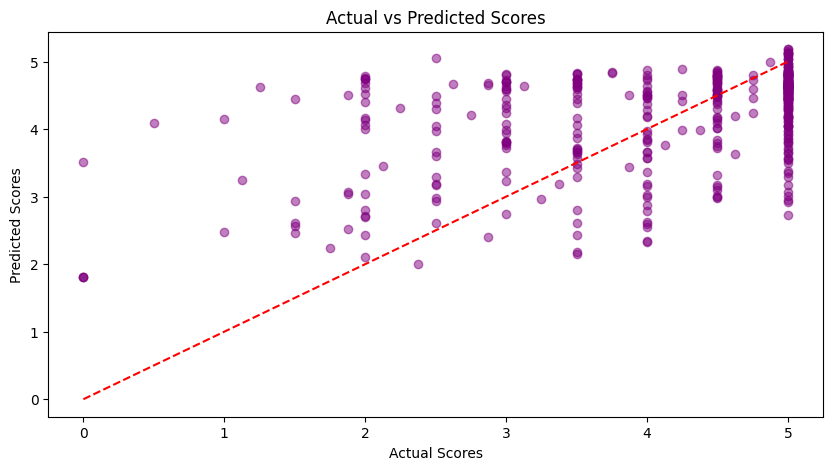

In [9]:
# Predictions vs Actual Scores
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # Ideal line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores')
plt.show()

In [10]:
from tensorflow.keras.models import save_model

In [11]:
# Assuming your model is named 'model'
model.save('sae.h5')

In [12]:
import pickle

In [15]:
# Assuming your model is named 'model'
with open('tokenizer.pkl', 'wb') as file:
       pickle.dump(model, file)